# Time-Series Clustering with GMM and LSTM Autoencoder

This notebook explores clustering techniques for time-series data using **Gaussian Mixture Models (GMM)** and **LSTM Autoencoders**.
We will:
1. Preprocess and scale the data.
2. Apply **PCA** for dimensionality reduction.
3. Perform **GMM clustering** on PCA-transformed data.
4. Train an **LSTM Autoencoder** to extract time-series features.
5. Apply **GMM clustering** on the extracted LSTM features.
6. Visualize the results.


# Load and Explore Data
- I am loading the dataset using Pandas and converting the date column to datetime.
- Checking for missing values and basic statistics to understand the dataset.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Load dataset
file_path = "clean_ts.csv"  
df = pd.read_csv(file_path)

# Display first few rows
df.head()


,city,size_rank,date,rent,value,newconstruciton_count,newconstruciton_pricepersqft,rent_affordability,home_owner_affordability,years_for_downpayment,...,empl_horeca,empl_professional_and_business_services,empl_transport_and_utilities,empl_information,empl_finance,empl_manufacuring,salary_hourly,electricity_price,population,fedfunds_rate
0,us,0.0,2015-01-31,1239.084338,183217.756229,NaN,NaN,0.260874,0.221400,6.705474,...,14915.0,19493.0,26556.0,2740.0,8059.0,12292.0,24.75,0.138,320997.0,0.11
1,us,0.0,2015-02-28,1245.449136,184006.426219,NaN,NaN,0.261258,0.222367,6.713469,...,14972.0,19537.0,26601.0,2741.0,8070.0,12301.0,24.79,0.138,321164.0,0.11
2,us,0.0,2015-03-31,1253.949928,184810.978304,NaN,NaN,0.261847,0.223824,6.724913,...,14981.0,19565.0,26647.0,2737.0,8081.0,12312.0,24.86,0.136,321344.0,0.11
3,us,0.0,2015-04-30,1263.898365,185695.148427,NaN,NaN,0.262205,0.222463,6.738901,...,15023.0,19609.0,26664.0,2742.0,8086.0,12318.0,24.89,0.137,321538.0,0.12
4,us,0.0,2015-05-31,1273.223333,186668.001104,NaN,NaN,0.262466,0.226078,6.755888,...,15103.0,19691.0,26728.0,2747.0,8097.0,12333.0,24.97,0.137,321740.0,0.12


# Data Preprocessing
- Filling missing values using forward fill (FFill).
- Scaling the data to normalize values before clustering.

In [5]:
# Convert the date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Check for missing values
print("Missing values in each column before filling:\n", df.isnull().sum())

# Handle missing values (forward and backward fill)
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

# Check again for missing values
print("\nMissing values after filling:\n", df.isnull().sum())

# Drop columns where >50% of values are NaN
df.dropna(axis=1, thresh=int(len(df) * 0.5), inplace=True)

# Select only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Ensure no NaNs before scaling
df_numeric.fillna(df_numeric.median(), inplace=True)

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_numeric)

# Show the scaled data
print("\nScaled data (first 5 rows):\n", data_scaled[:5])

Missing values in each column before filling:
 city                                         0
size_rank                                    0
date                                         0
rent                                         0
value                                        0
newconstruciton_count                      148
newconstruciton_pricepersqft               148
rent_affordability                           8
home_owner_affordability                    12
years_for_downpayment                       12
new_renter_income_needed                     8
affordable_home_price                       12
median_sale_price                            4
unemployment                                 3
cpi                                         87
empl_services                                3
empl_total_nonfarm                           3
empl_mining                                  3
empl_wholesale                               3
empl_localgov                                3
empl_horeca  

In [6]:
missing_cols = set(['newconstruciton_count', 'newconstruciton_pricepersqft']) - set(df.columns)
print("Missing columns:", missing_cols)


Missing columns: set()


# Time-Series Visualization
- Plotting the rent and house valuation data over time.
- This helps in understanding trends and seasonality.


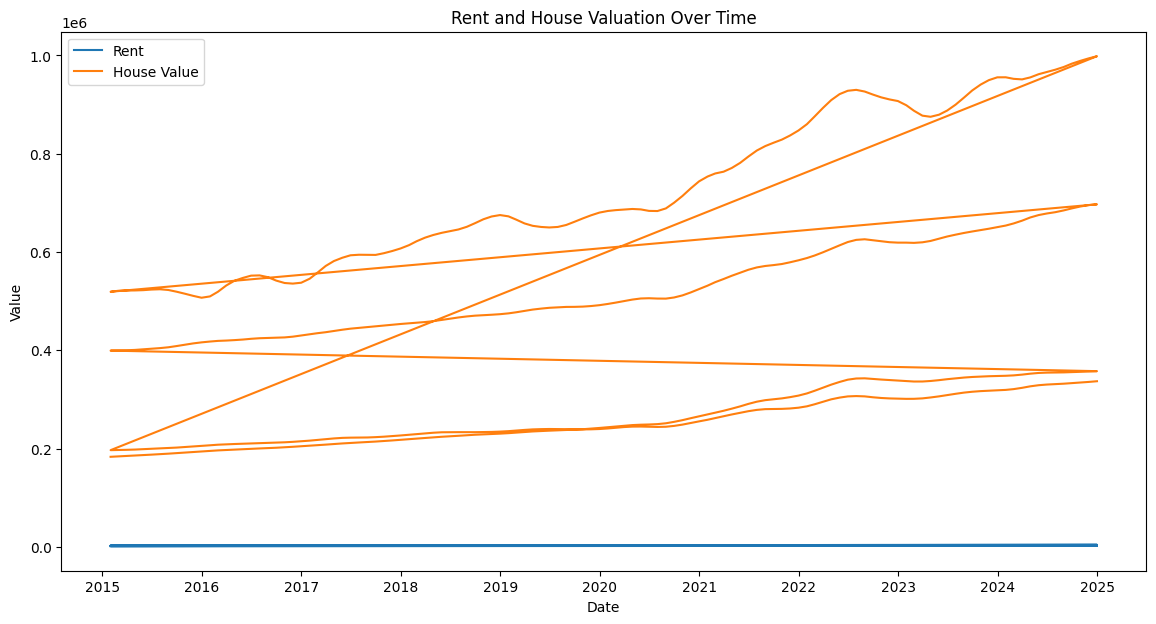

In [8]:
# Plot rent and house valuation data over time
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['rent'], label='Rent')
plt.plot(df['date'], df['value'], label='House Value')
plt.title('Rent and House Valuation Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


Possible Cause: If rent was forward/backward filled too much, it might have lost real variations.

In [10]:
print(df['rent'].describe())
print(df['rent'].nunique())  # Check how many unique values exist


count     480.000000
mean     2378.162989
std       794.185068
min      1239.084338
25%      1628.185256
50%      2295.641382
75%      2971.576191
max      4181.355392
Name: rent, dtype: float64
480


Normalize House Value and Rent Value to be comparable

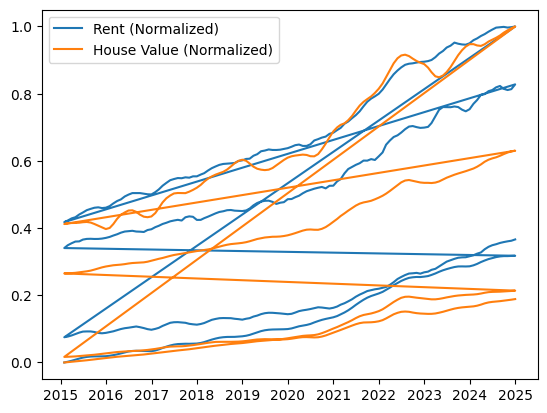

In [12]:
df['rent_norm'] = (df['rent'] - df['rent'].min()) / (df['rent'].max() - df['rent'].min())
df['value_norm'] = (df['value'] - df['value'].min()) / (df['value'].max() - df['value'].min())

plt.plot(df['date'], df['rent_norm'], label='Rent (Normalized)')
plt.plot(df['date'], df['value_norm'], label='House Value (Normalized)')
plt.legend()
plt.show()


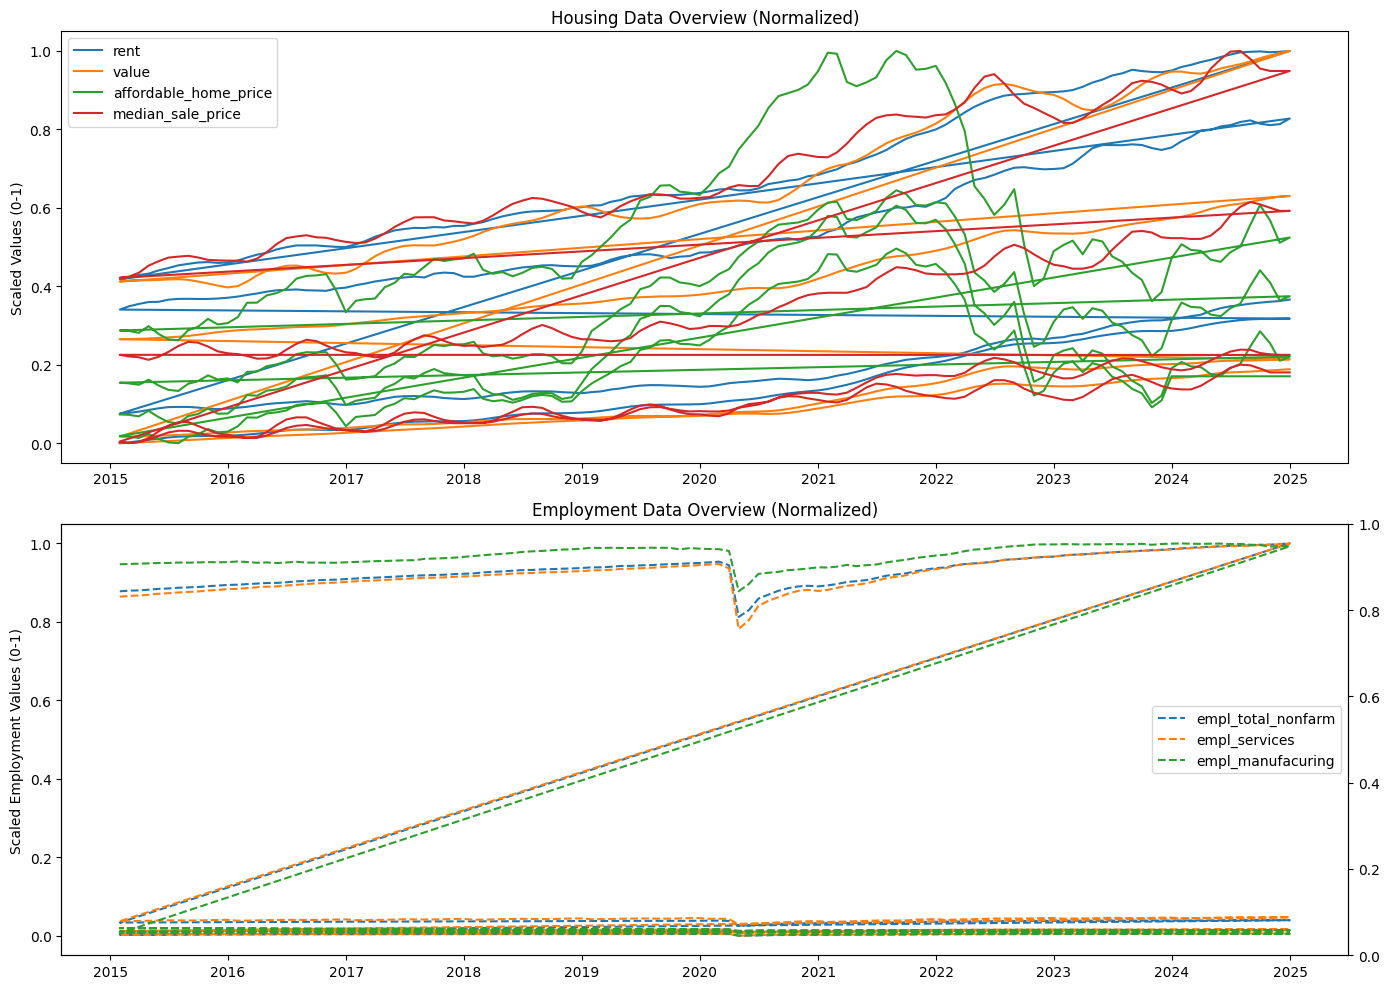

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns to normalize
housing_cols = ['rent', 'value', 'affordable_home_price', 'median_sale_price']
employment_cols = ['empl_total_nonfarm', 'empl_services', 'empl_manufacuring']

# Normalize selected columns
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[housing_cols + employment_cols] = scaler.fit_transform(df[housing_cols + employment_cols])

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Housing data with normalization
for col in housing_cols:
    axs[0].plot(df['date'], df_normalized[col], label=col)
axs[0].set_title("Housing Data Overview (Normalized)")
axs[0].set_ylabel("Scaled Values (0-1)")
axs[0].legend()

#  Employment data with dual y-axis
ax2 = axs[1].twinx()  # Create a secondary y-axis
axs[1].set_title("Employment Data Overview (Normalized)")

for col in employment_cols:
    axs[1].plot(df['date'], df_normalized[col], label=col, linestyle="--")

axs[1].set_ylabel("Scaled Employment Values (0-1)")
axs[1].legend()

# Improve layout
plt.tight_layout()
plt.show()

# Time-Series Clustering (DTW-based KMeans)
- Using Dynamic Time Warping (DTW) to cluster time-series data.
- DTW helps capture shape similarities rather than just numerical distance.
- Visualizing the clusters to see how time-series are grouped.


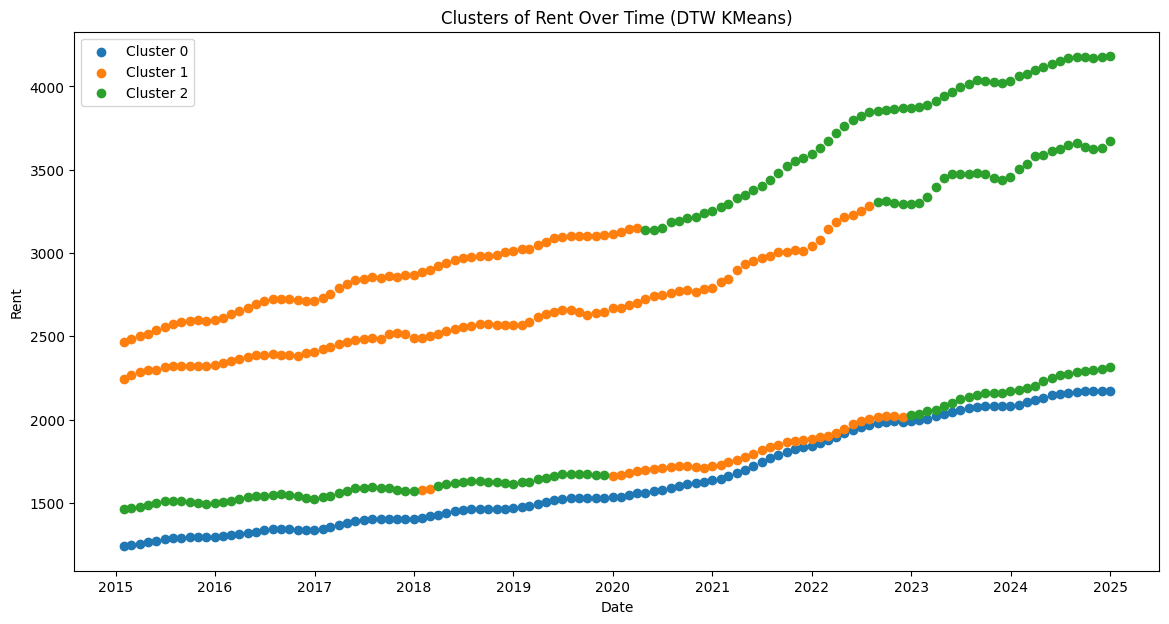

In [32]:
# Time-Series KMeans using DTW
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)

# Fit and predict clusters
df['cluster_dtw'] = ts_kmeans.fit_predict(data_scaled)

# Plot the clusters
plt.figure(figsize=(14, 7))
for cluster in df['cluster_dtw'].unique():
    plt.scatter(df[df['cluster_dtw'] == cluster]['date'], df[df['cluster_dtw'] == cluster]['rent'], label=f'Cluster {cluster}')
plt.title('Clusters of Rent Over Time (DTW KMeans)')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


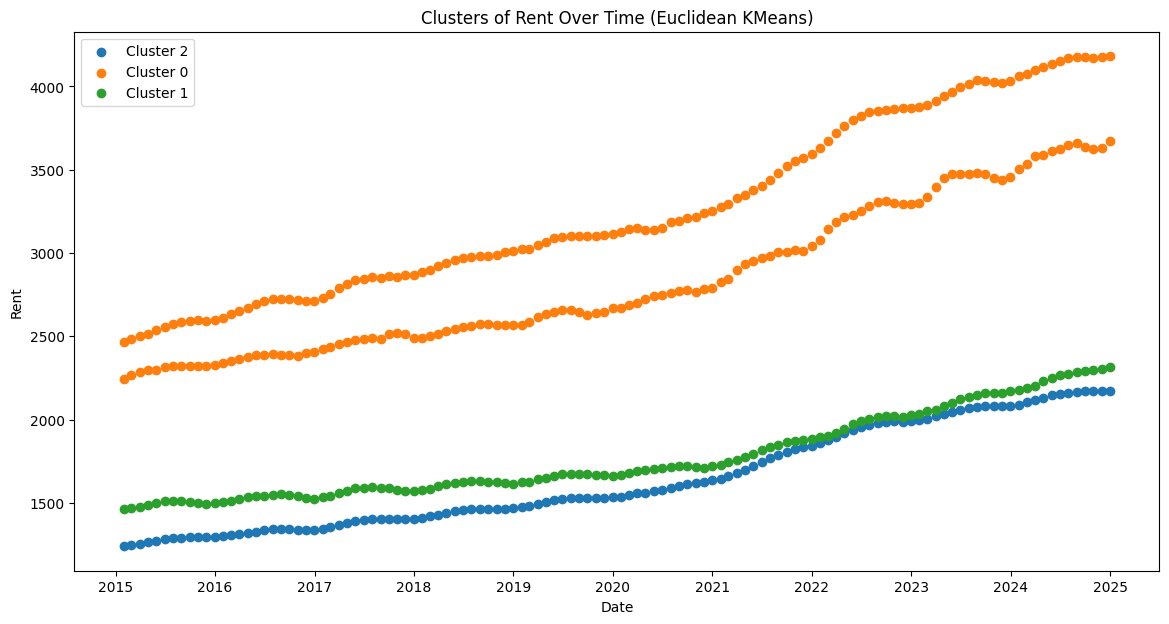

In [36]:
#Used Euclidean Distance 

from tslearn.clustering import TimeSeriesKMeans

n_clusters = 3
ts_kmeans_euclidean = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=42)

# Fit and predict clusters
df['cluster_euclidean'] = ts_kmeans_euclidean.fit_predict(data_scaled)

# Plot clusters
plt.figure(figsize=(14, 7))
for cluster in df['cluster_euclidean'].unique():
    plt.scatter(df[df['cluster_euclidean'] == cluster]['date'], 
                df[df['cluster_euclidean'] == cluster]['rent'], 
                label=f'Cluster {cluster}')
plt.title('Clusters of Rent Over Time (Euclidean KMeans)')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


In [34]:
# Group by cluster and check average rent, min/max, std deviation
df.groupby('cluster_dtw')['rent'].describe()


,count,mean,std,min,25%,50%,75%,max
cluster_dtw,,,,,,,,
0,120.0,1642.957086,299.864766,1239.084338,1399.084294,1534.505097,1956.980708,2173.600292
1,192.0,2532.717643,433.130009,1576.007019,2323.538537,2589.056238,2854.875457,3281.922531
2,168.0,2726.676170,996.196962,1460.061936,1622.031762,3142.639734,3624.777875,4181.355392


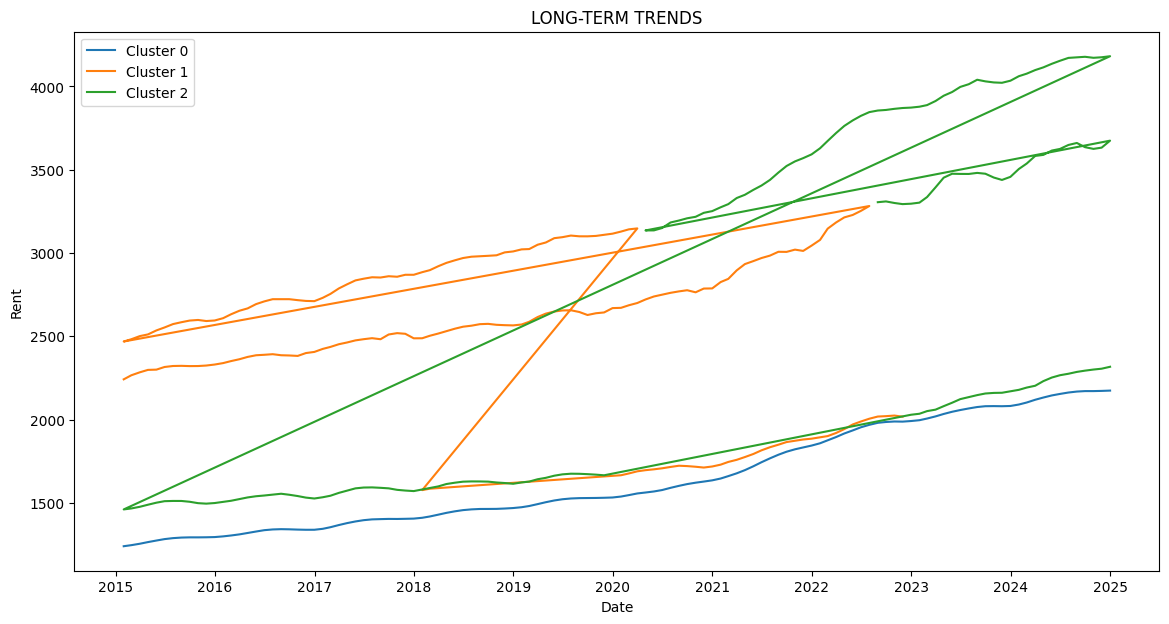

In [40]:
plt.figure(figsize=(14, 7))

for cluster in df['cluster_dtw'].unique():
    subset = df[df['cluster_dtw'] == cluster]
    plt.plot(subset['date'], subset['rent'], label=f'Cluster {cluster}')

plt.title('LONG-TERM TRENDS')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


Map to cities

In [43]:
# Count how many times each city appears in each cluster
city_cluster_distribution = df.groupby(['city', 'cluster_dtw']).size().unstack()

# Display the distribution table
print(city_cluster_distribution)


cluster_dtw      0     1     2
city                          
chicago        NaN  38.0  82.0
la             NaN  63.0  57.0
nyc            NaN  91.0  29.0
us           120.0   NaN   NaN


<Figure size 1400x700 with 0 Axes>

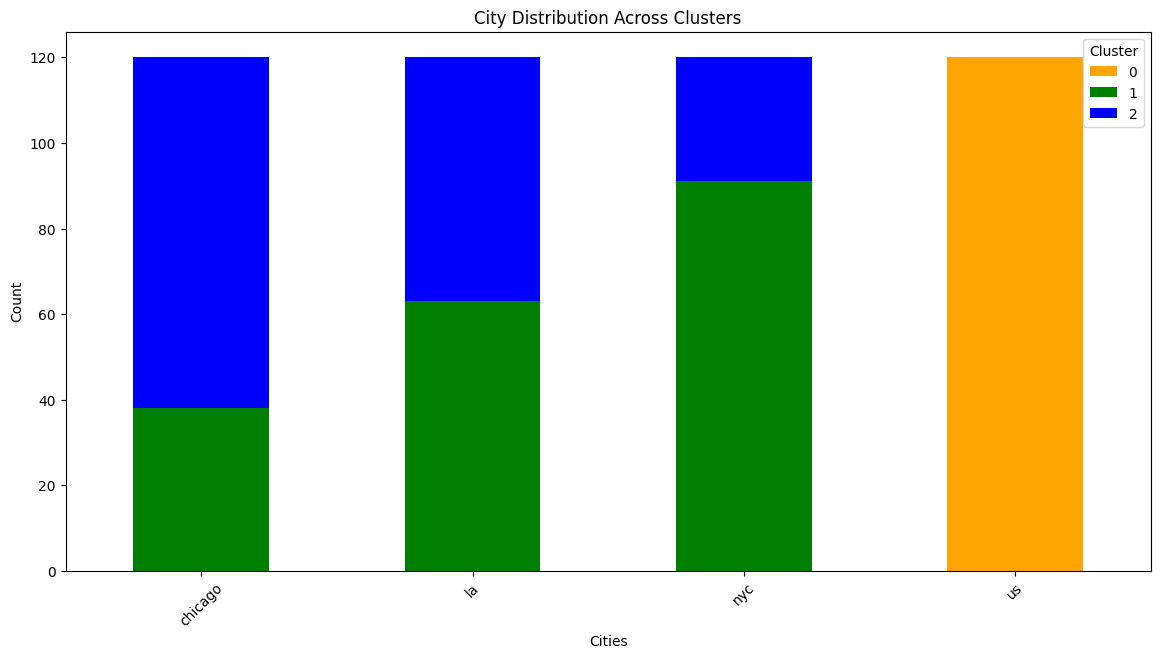

In [45]:
import seaborn as sns
plt.figure(figsize=(14, 7))

# Define custom colors for each cluster
cluster_colors = {0: 'orange', 1: 'green', 2: 'blue'}

# Plot city distribution with custom colors
city_cluster_distribution.plot(
    kind='bar', 
    stacked=True, 
    figsize=(14, 7), 
    color=[cluster_colors[col] for col in city_cluster_distribution.columns]  # Apply custom colors
)

plt.title("City Distribution Across Clusters")
plt.xlabel("Cities")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.show()



# Feature Extraction
- Extracting statistical and shape-based features from time-series.
- This converts the time-series into a feature matrix for alternative clustering.


In [48]:
# Fix column names before extraction
df.columns = [col.replace("__", "_") for col in df.columns]

required_cols = ['lstm_cluster', 'date', 'city']
existing_cols = [col for col in required_cols if col in df.columns]

df = df.dropna(subset=existing_cols)

# Remove columns with too many NaNs before extraction (e.g., if >50% missing)
df = df.dropna(axis=1, thresh=int(len(df) * 0.5))

# Fill remaining NaNs in numeric columns with median (or use another method)
df = df.fillna(df.median(numeric_only=True))


In [50]:
# Cap extreme values in numeric columns (optional)
for col in df.select_dtypes(include=['number']).columns:
    df[col] = df[col].clip(lower=df[col].quantile(0.01), upper=df[col].quantile(0.99))


In [52]:
# Extract features safely
extracted_features = extract_features(df, column_id='city', column_sort='date')

# Drop columns where >50% of values are NaN (remove useless features)
extracted_features = extracted_features.dropna(thresh=len(extracted_features) * 0.5, axis=1)

# Fill remaining NaNs with zero or another imputation strategy
extracted_features = impute(extracted_features)

# Rename columns to avoid "__" issues
extracted_features.columns = [col.replace("__", "_") for col in extracted_features.columns]

# Reset index and ensure proper merging
extracted_features.reset_index(inplace=True)
extracted_features.rename(columns={'index': 'city'}, inplace=True)

# Convert 'city' to string for consistency
df['city'] = df['city'].astype(str)
extracted_features['city'] = extracted_features['city'].astype(str)

# Merge back with original dataset
df = df.merge(extracted_features, on="city", how="left")

# Debugging: Check if cities are missing after merging
missing_cities = df[~df['city'].isin(extracted_features['city'])]
print("Cities missing in extracted features:", missing_cities['city'].unique())


Feature Extraction: 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]


Cities missing in extracted features: []


In [53]:
print(extracted_features.head())


      city  size_rank_variance_larger_than_standard_deviation  \
0  chicago                                                0.0   
1       la                                                0.0   
2      nyc                                                0.0   
3       us                                                0.0   

   size_rank_has_duplicate_max  size_rank_has_duplicate_min  \
0                          1.0                          1.0   
1                          1.0                          1.0   
2                          1.0                          1.0   
3                          1.0                          1.0   

   size_rank_has_duplicate  size_rank_sum_values  size_rank_abs_energy  \
0                      1.0                 360.0                1080.0   
1                      1.0                 240.0                 480.0   
2                      1.0                 120.0                 120.0   
3                      1.0                   0.0              

In [54]:
print(df.head())


  city  size_rank       date         rent          value  \
0   us        0.0 2015-01-31  1280.020494  187412.265129   
1   us        0.0 2015-02-28  1280.020494  187412.265129   
2   us        0.0 2015-03-31  1280.020494  187412.265129   
3   us        0.0 2015-04-30  1280.020494  187412.265129   
4   us        0.0 2015-05-31  1280.020494  187412.265129   

   newconstruciton_count  newconstruciton_pricepersqft  rent_affordability  \
0                31548.0                    137.134466            0.260874   
1                31548.0                    137.134466            0.261258   
2                31548.0                    137.134466            0.261847   
3                31548.0                    137.134466            0.262205   
4                31548.0                    137.134466            0.262466   

   home_owner_affordability  years_for_downpayment  ...  \
0                  0.221400               6.705474  ...   
1                  0.222367               6.713469  

# Feature-Based Clustering (K-Means)
- Clustering the extracted features instead of raw time-series data.
- Using PCA to reduce dimensionality for better performance.

C:\Users\delia\anaconda3\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\delia\anaconda3\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


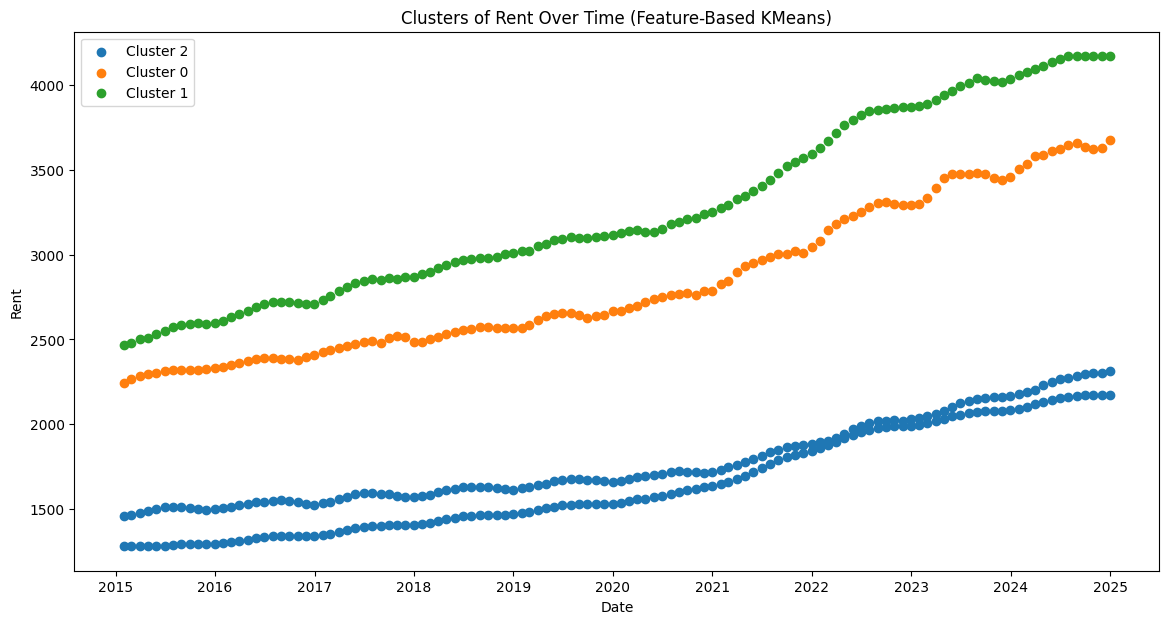

In [56]:
import os
os.environ["OMP_NUM_THREADS"] = "2"

# Drop non-numeric columns before PCA
numeric_features = df.select_dtypes(include=['number'])

# Apply PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(numeric_features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster_features'] = kmeans.fit_predict(features_pca)


# Plot clusters
plt.figure(figsize=(14, 7))
for cluster in df['cluster_features'].unique():
    plt.scatter(df[df['cluster_features'] == cluster]['date'], df[df['cluster_features'] == cluster]['rent'], label=f'Cluster {cluster}')
plt.title('Clusters of Rent Over Time (Feature-Based KMeans)')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


# Comparing Clustering Approaches
- Time-Series Clustering (DTW) captures shape similarities but is computationally expensive.
- Feature-Based Clustering is more interpretable but depends on feature selection.
- Silhouette Score helps evaluate which method works better.

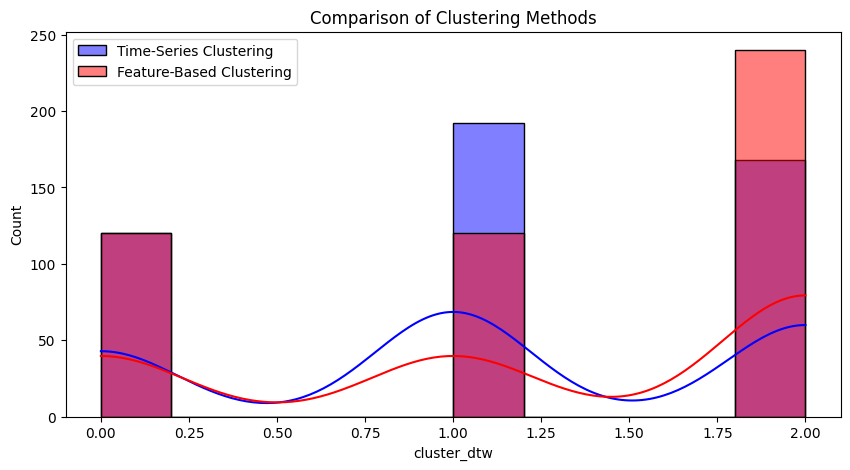

In [58]:
# Ensure 'labels_ts' is defined from DTW clustering
labels_ts = df['cluster_dtw']  # Check if this column stores DTW cluster labels

# Ensure 'labels_features' is defined from feature-based KMeans clustering
labels_features = df['cluster_features']  # This comes from PCA + KMeans

# Now, we can plot
plt.figure(figsize=(10, 5))
sns.histplot(labels_ts, label='Time-Series Clustering', kde=True, color='blue', alpha=0.5)
sns.histplot(labels_features, label='Feature-Based Clustering', kde=True, color='red', alpha=0.5)
plt.legend()
plt.title("Comparison of Clustering Methods")
plt.show()


# Evaluating Clustering Performance
- Using Silhouette Score to assess the quality of the clusters.
- Higher scores indicate better-defined clusters.


In [71]:
from sklearn.metrics import silhouette_score

silhouette_ts = silhouette_score(data_scaled, labels_ts)
silhouette_features = silhouette_score(features_pca, labels_features)

print("Silhouette Score - Time-Series Clustering:", silhouette_ts)
print("Silhouette Score - Feature-Based Clustering:", silhouette_features)


Silhouette Score - Time-Series Clustering: 0.28734753509980154
Silhouette Score - Feature-Based Clustering: 0.9584660515457407


# Conclusion
- Both methods have advantages: DTW for shape-based similarity, feature-based for interpretation.
- The best approach depends on the use case.
- More experiments can be done with different clustering methods and parameters.


GMM Clustering with PCA**
To reduce dimensionality while preserving variance, we use **Principal Component Analysis (PCA)** and then apply **Gaussian Mixture Models (GMM)**.
"""

C:\Users\delia\anaconda3\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


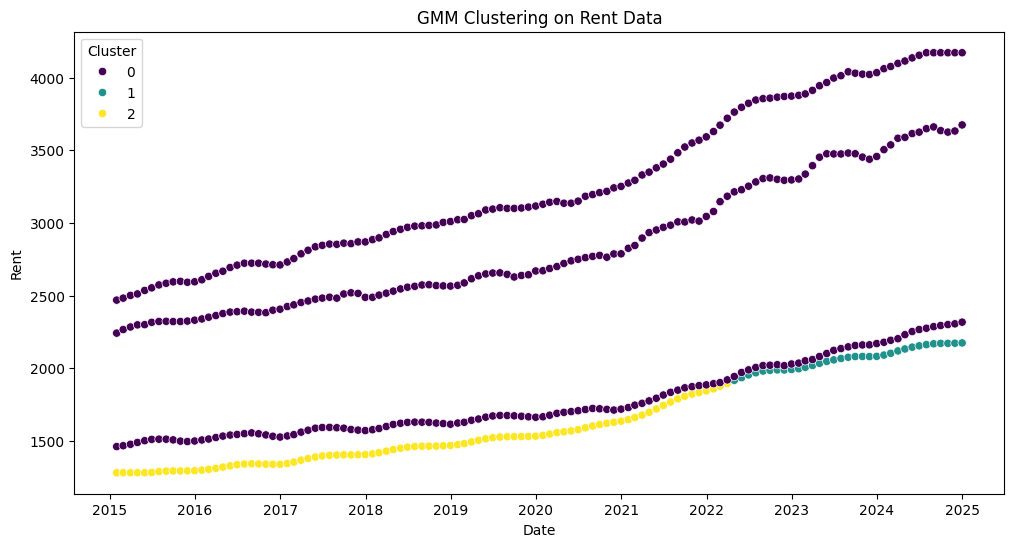

In [75]:
# Reduce dimensions using PCA
pca = PCA(n_components=5)
data_pca = pca.fit_transform(data_scaled)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=3, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(data_pca)

"""
# Visualization: GMM Clusters
We plot the clusters identified by GMM to analyze trends in rent over time.
"""

plt.figure(figsize=(12,6))
sns.scatterplot(x=df['date'], y=df['rent'], hue=df['gmm_cluster'], palette='viridis')
plt.title('GMM Clustering on Rent Data')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend(title='Cluster')
plt.show()


---LSTM Autoencoder for Feature Extraction---
We train an **LSTM Autoencoder** to learn a compressed representation of the time-series data, which we later use for clustering.

In [ ]:
def create_lstm_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(50, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(25, activation='relu', return_sequences=False)(encoded)
    
    decoded = RepeatVector(input_shape[0])(encoded)
    decoded = LSTM(25, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(50, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)
    
    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [ ]:
"""
# Data Preparation for LSTM
We reshape the data into a 3D format suitable for LSTM input: (samples, time_steps, features).
"""

time_steps = 10  # Window size
features = data_scaled.shape[1]
X_lstm = np.array([data_scaled[i-time_steps:i] for i in range(time_steps, len(data_scaled))])

"""
# Train LSTM Autoencoder
We train the LSTM Autoencoder and extract the compressed feature representation.
"""

autoencoder, encoder = create_lstm_autoencoder((time_steps, features))
autoencoder.fit(X_lstm, X_lstm, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

"""
# Extract LSTM Features
The encoder part of the autoencoder is used to extract meaningful representations.
"""

lstm_features = encoder.predict(X_lstm)

"""
# GMM Clustering on LSTM Features
We apply GMM on the extracted LSTM features to analyze time-series patterns.
"""

gmm_lstm = GaussianMixture(n_components=3, random_state=42)
lstm_clusters = gmm_lstm.fit_predict(lstm_features)
df['lstm_cluster'] = np.nan
df.loc[time_steps:, 'lstm_cluster'] = lstm_clusters  # Offset due to windowing

"""
# Visualization: LSTM Feature-based Clustering
Finally, we plot the clusters based on LSTM-derived features to observe different rent trends.
"""

plt.figure(figsize=(12,6))
sns.scatterplot(x=df['date'][time_steps:], y=df['rent'][time_steps:], hue=df['lstm_cluster'][time_steps:], palette='coolwarm')
plt.title('LSTM Feature-based Clustering')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend(title='Cluster')
plt.show()
